In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import pandas as pd

In [38]:
f = 'audio.wav'

samplerate, data = wavfile.read(f)
print('Частота дискретизации:',samplerate)
print('Размерность данных:',np.shape(data))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate)
time = time[:len(time)]

print(f"Длительность {duration} \nВременная шкала {time} \nРазмерность времени {len(time)}")

canal1 = data[:,0]
canal2 = data[:,1]

Частота дискретизации: 48000
Размерность данных: (11392453, 2)
Длительность 237.34277083333333 
Временная шкала [0.00000000e+00 2.08333333e-05 4.16666667e-05 ... 2.37342708e+02
 2.37342729e+02 2.37342750e+02] 
Размерность времени 11392453


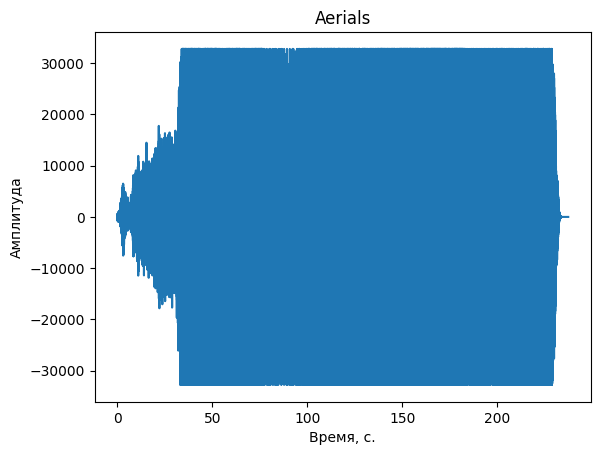

In [39]:
plt.plot(time, canal1)
plt.xlabel('Время, с.')
plt.ylabel('Амплитуда')
plt.title('Aerials')
plt.show()

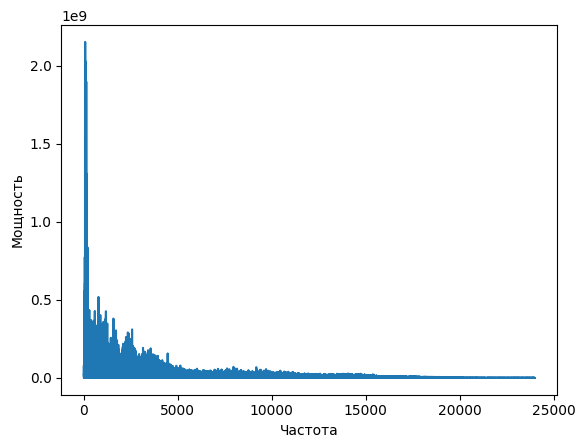

In [40]:
# работаем с 1м каналом

from scipy.fft import  rfft, rfftfreq, irfft


# число точек в normalized_tone
N = int(samplerate * duration)

yf = rfft(canal1)
xf = rfftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

In [41]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(xf) / (max(xf))

# Наши целевые частоты 
target_idx_hf = int(points_per_freq * 800)
target_idx_lf = int(points_per_freq * 400)

yf_hf = yf.copy()
yf_lf = yf.copy()
yf_bp = yf.copy()
yf_zagr = yf.copy()


yf_hf[:target_idx_hf] = 0

yf_lf[target_idx_lf:] = 0

yf_bp[:target_idx_lf] = 0
yf_bp[target_idx_hf:] = 0



yf_zagr[target_idx_lf:target_idx_hf] = 0

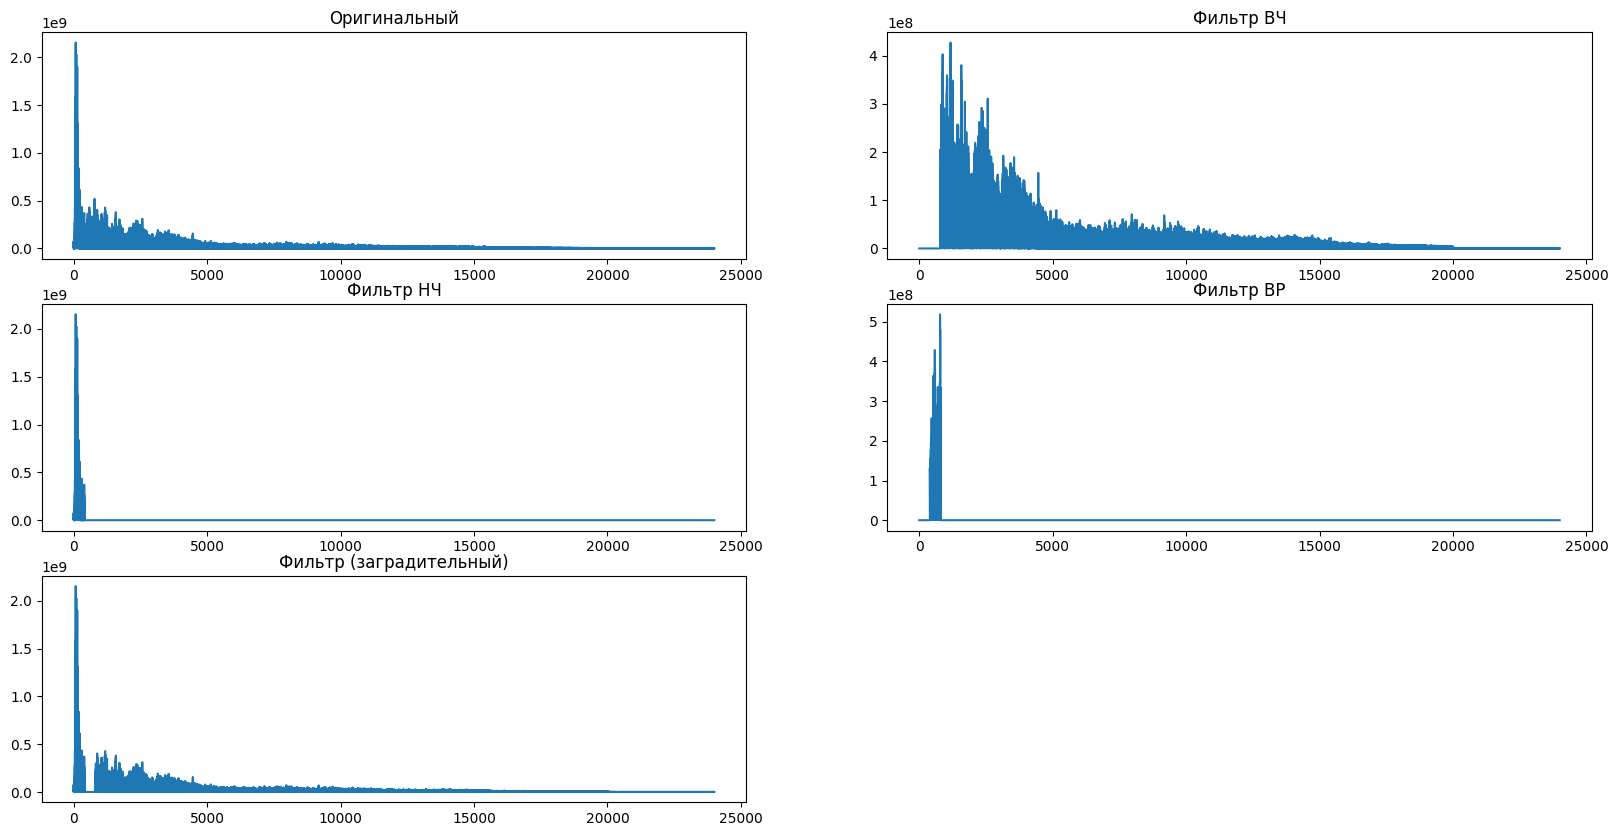

In [42]:
fig, ax = plt.subplots(nrows= 3 , ncols= 2, figsize=(20, 10) )

ax[0,0].plot(xf, np.abs(yf))
ax[0,0].set_title("Оригинальный")

ax[0,1].plot(xf, np.abs(yf_hf))
ax[0,1].set_title("Фильтр ВЧ")      # Отсекаем нижние частоты 

ax[1,0].plot(xf, np.abs(yf_lf))
ax[1,0].set_title("Фильтр НЧ")      # Отсекаем верхние частоты

ax[1,1].plot(xf, np.abs(yf_bp))
ax[1,1].set_title("Фильтр BP")      # Отсекаем верхние и нижние по порогу

ax[2,0].plot(xf,np.abs(yf_zagr))
ax[2,0].set_title("Фильтр (заградительный)") # Обратный предыдущему

ax[2,1].set_axis_off()

plt.xlabel('Частота')
plt.ylabel('Амплитуда')

plt.show()

In [43]:
new_sig_hf = irfft(yf_hf)
new_sig_lf = irfft(yf_lf)
new_sig_bp = irfft(yf_bp)
new_sig_zagr = irfft(yf_zagr)

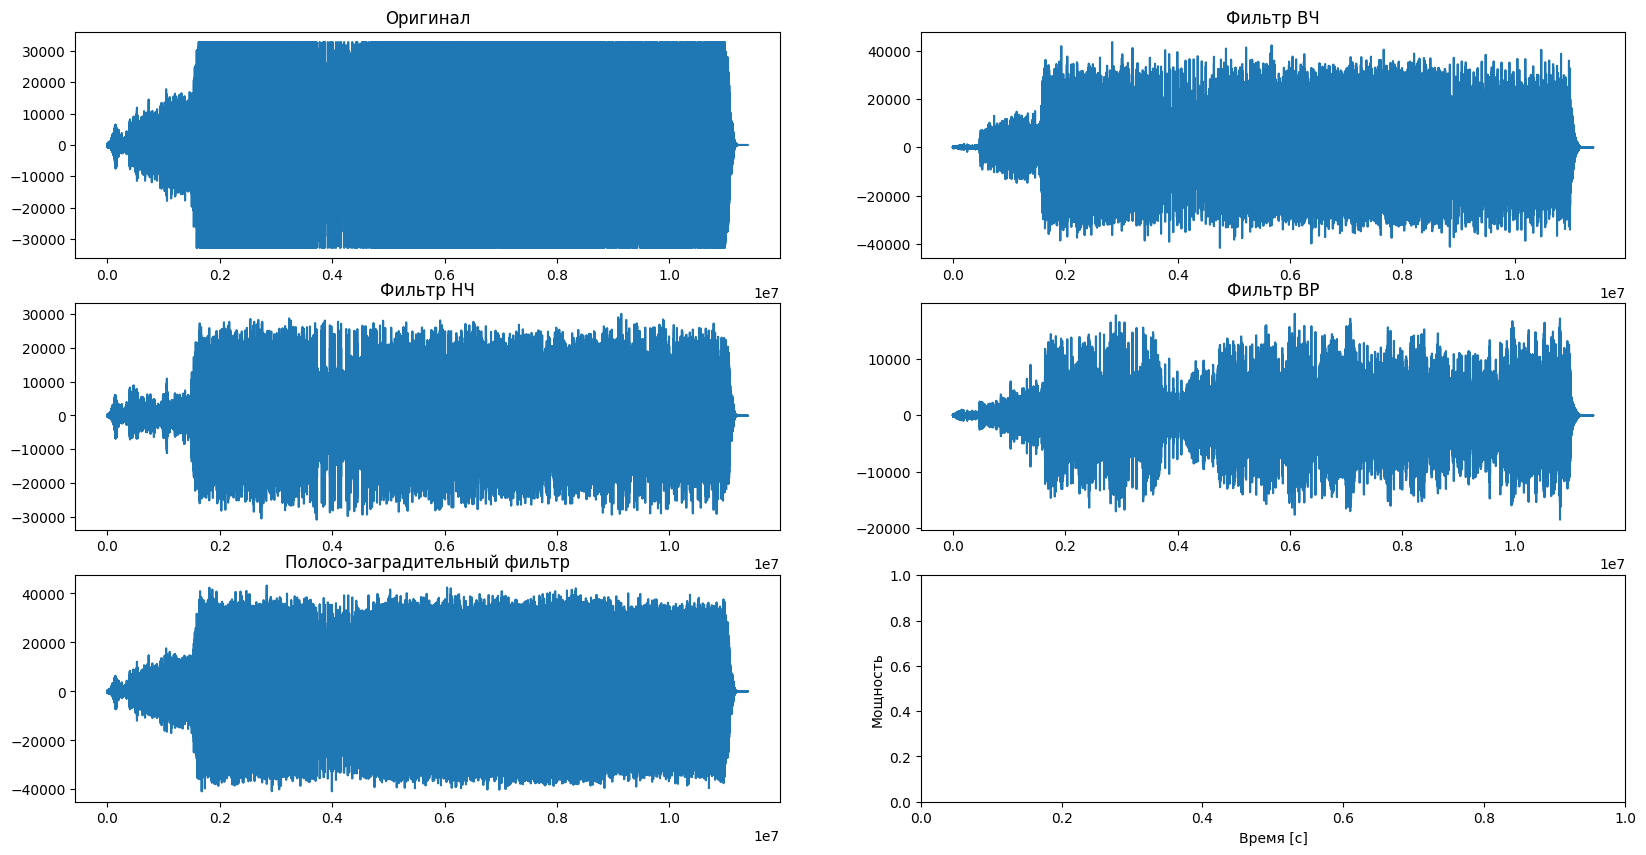

In [44]:
fig, ax = plt.subplots(nrows=3 , ncols=2, figsize=(20, 10))

ax[0,0].plot(canal1)
ax[0,0].set_title("Оригинал")

ax[0,1].plot(irfft(yf_hf))
ax[0,1].set_title("Фильтр ВЧ")

ax[1,0].plot(irfft(yf_lf))
ax[1,0].set_title("Фильтр НЧ")

ax[1,1].plot(irfft(yf_bp))
ax[1,1].set_title("Фильтр BP")

ax[2,0].plot(irfft(yf_zagr))
ax[2,0].set_title("Полосо-заградительный фильтр")

plt.xlabel('Время [с]')
plt.ylabel('Мощность')

plt.show()

In [45]:
def exponential_smoothing(values, alpha):
    result = [values[0], values[1]]    
    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n-1])    
    return result

def plot_exponential_smoothing(series, alphas):
    with plt.style.context("_classic_test_patch"):  
        plt.figure(figsize=(15, 7))

        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            plt.plot(exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha))

        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

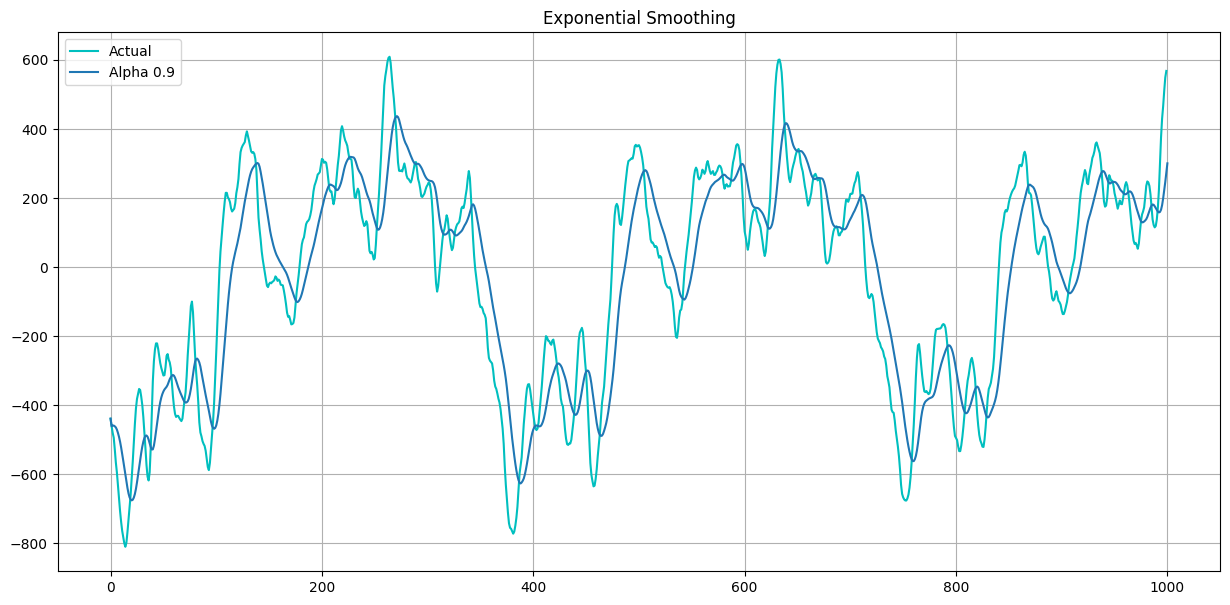

In [46]:
values = pd.Series([np.arange(len(canal1[20000:21000])),canal1[20000:21000]])
plot_exponential_smoothing(pd.Series([np.arange(len(canal1[20000:21000])),canal1[20000:21000]]),[0.9])

In [47]:
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values):
            value = values[-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plot_double_exponential_smoothing(signal_part, alphas, betas):    
    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(signal_part, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(signal_part, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

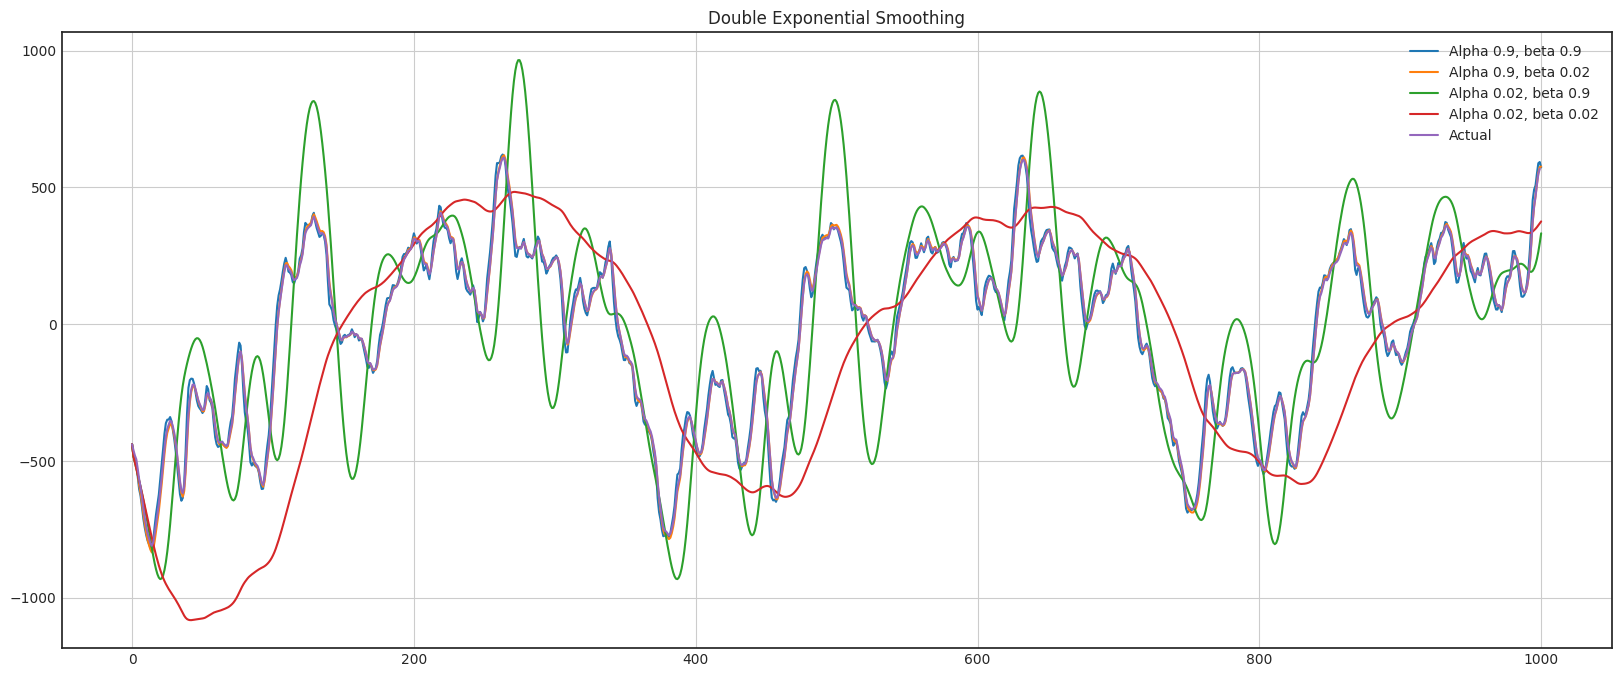

In [48]:
plot_double_exponential_smoothing(canal1[20000:21000],alphas=[0.9,0.02],betas=[0.9,0.02])

In [49]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)

    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))

    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

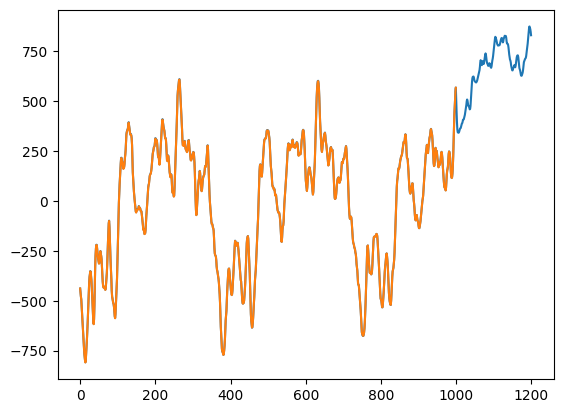

In [102]:
res = triple_exponential_smoothing(canal1[20000:21000],200,0.716,0.002,0.999,200)
plt.plot(res) 
plt.plot(canal1[20000:21000])

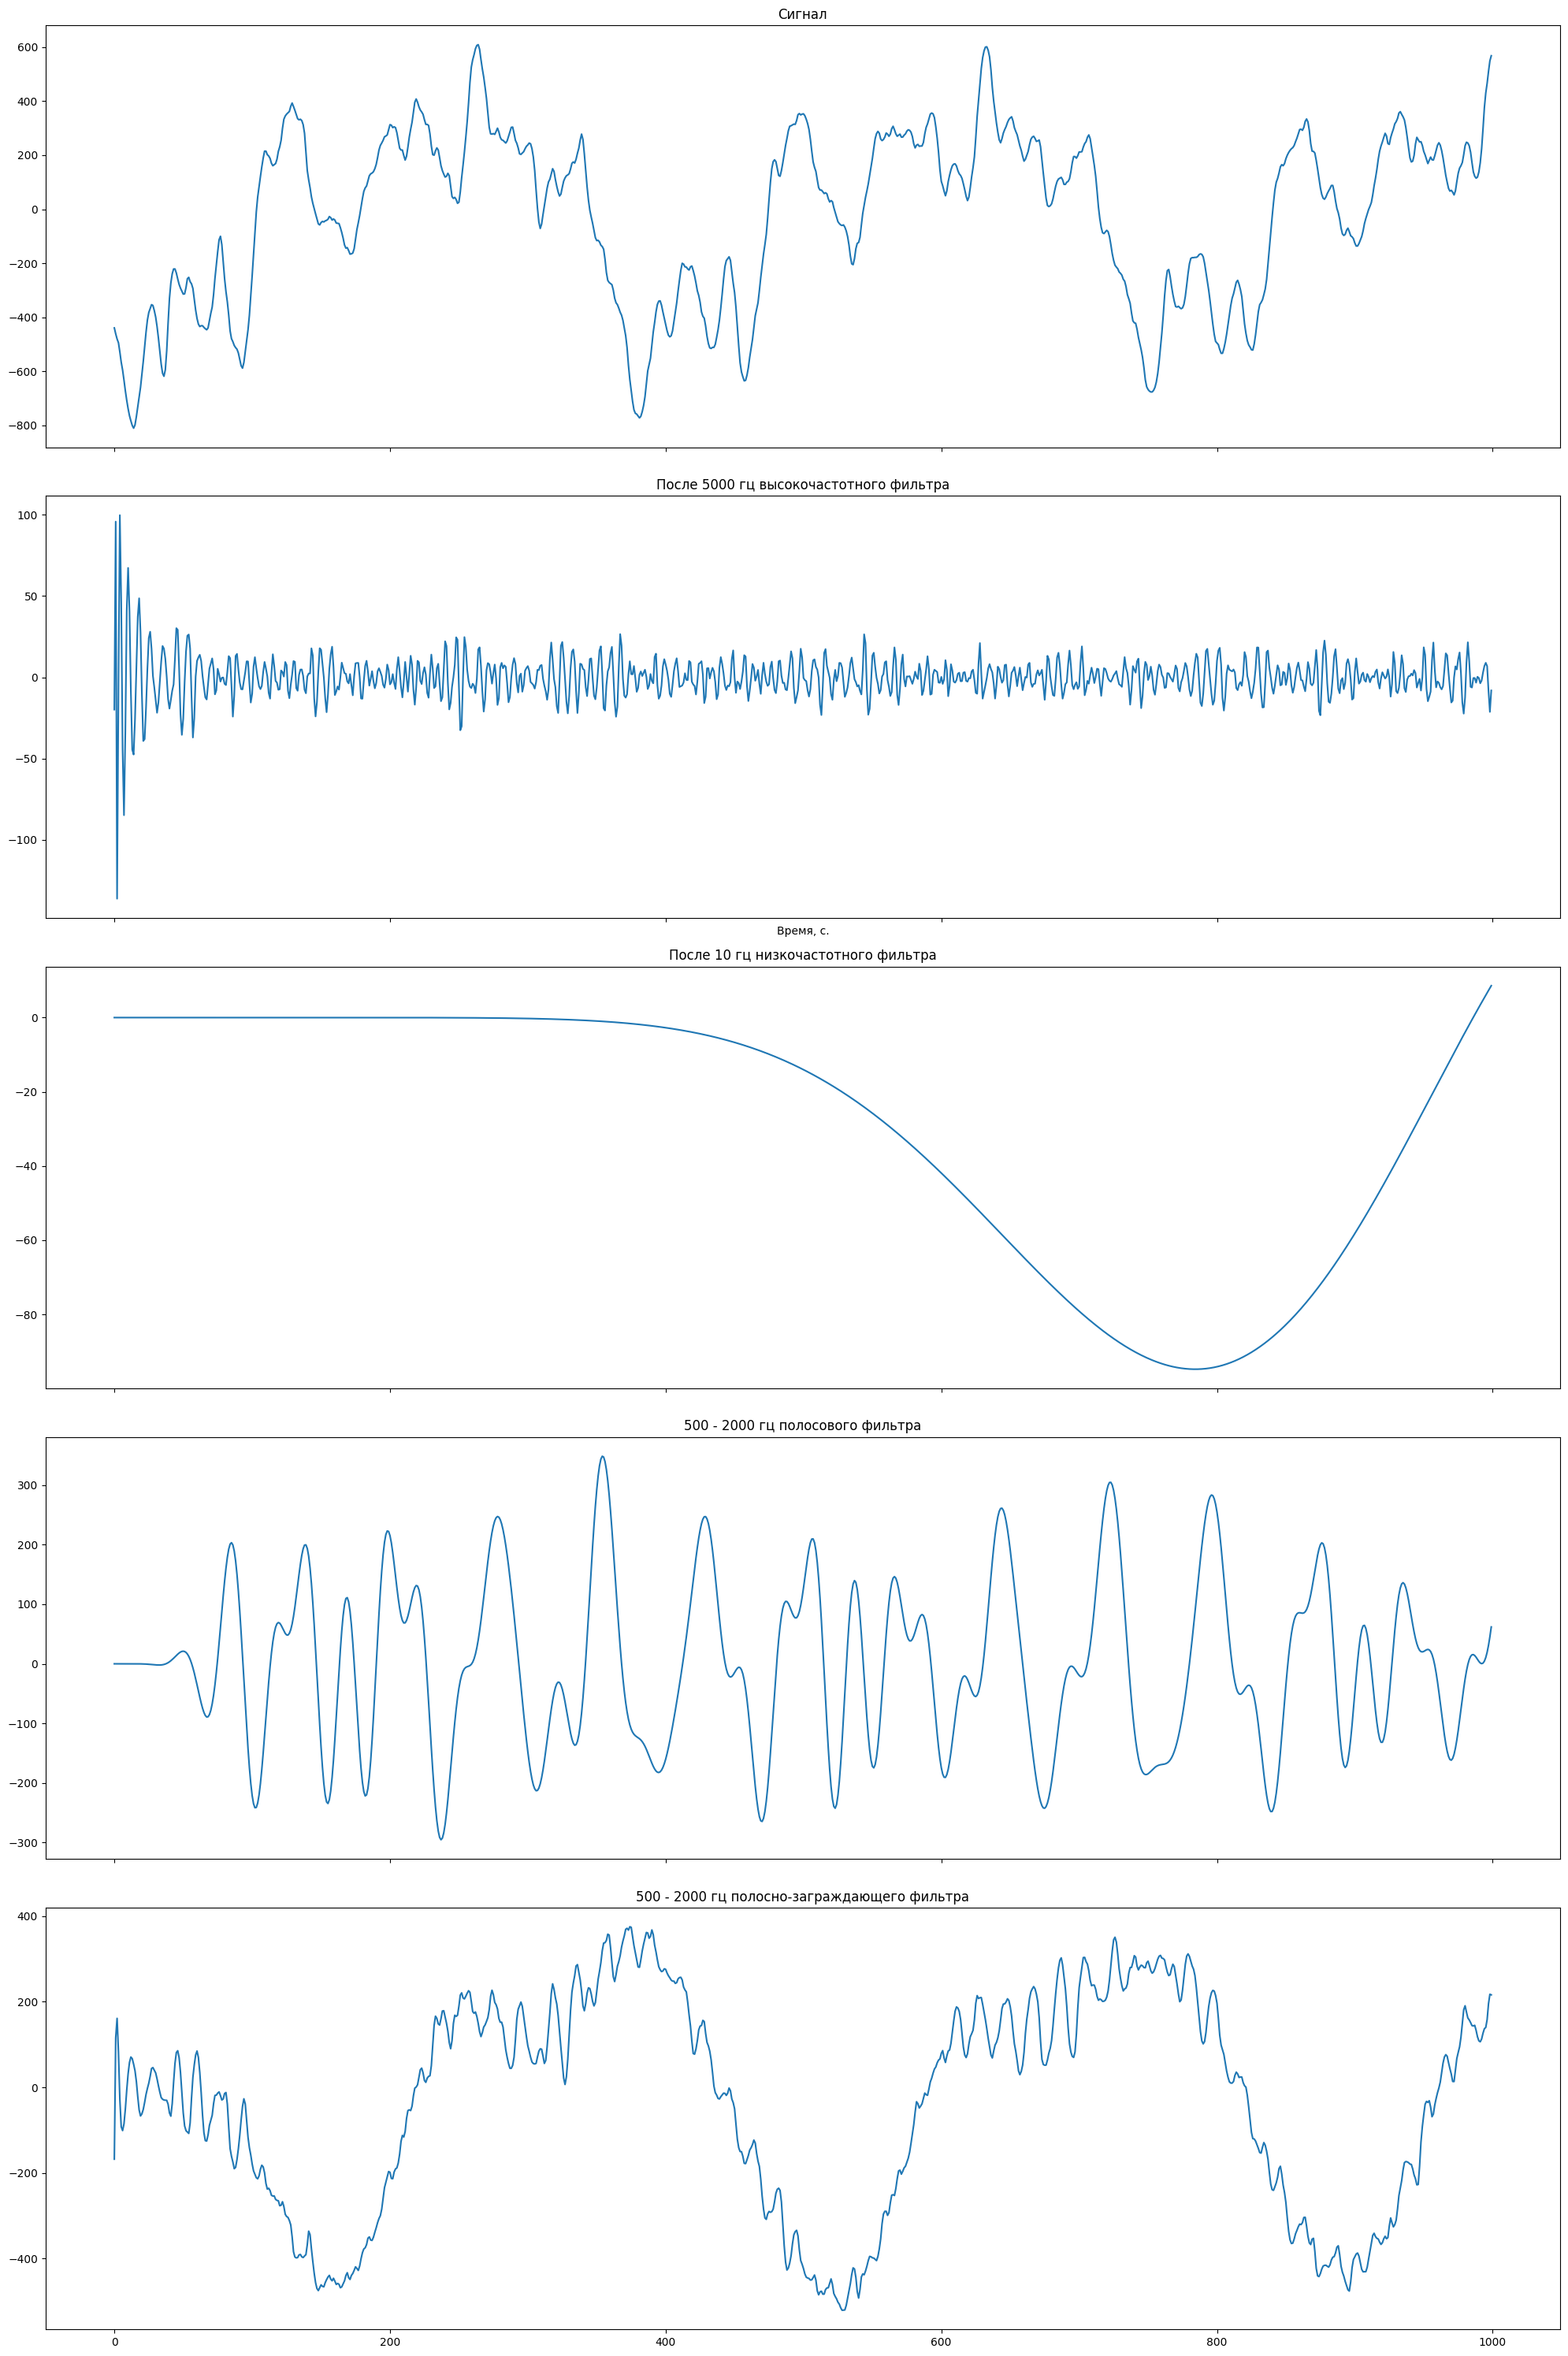

In [103]:
signal_part = canal1[20000:21000]

sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=samplerate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)

sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=samplerate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)

sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=samplerate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=samplerate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(signal_part)
ax1.set_title('Сигнал')

ax2.plot(filtered_hp)
ax2.set_title('После 5000 гц высокочастотного фильтра')

ax3.plot(filtered_lp)
ax3.set_title('После 10 гц низкочастотного фильтра')

ax4.plot(filtered_bp)
ax4.set_title('500 - 2000 гц полосового фильтра')
 
ax5.plot(filtered_bs)
ax5.set_title('500 - 2000 гц полосно-заграждающего фильтра')

ax2.set_xlabel('Время, с.')
plt.tight_layout()
plt.show()

In [52]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

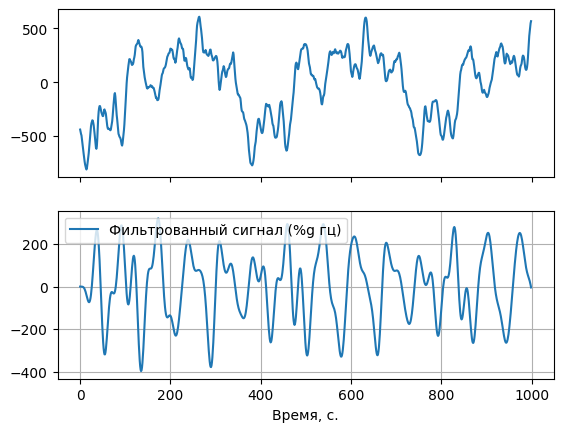

In [104]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = samplerate

lowcut = 500.0
highcut = 2000.0


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(signal_part, label='Зашумленный сигнал')

y = butter_bandpass_filter(signal_part, lowcut, highcut, fs, order=6)
ax2.plot(y, label='Фильтрованный сигнал (%g гц)')

plt.xlabel('Время, с.')
 
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()